In [1]:
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import pickle

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# !pip install pandas

In [3]:
data_path = '../data/work'

In [4]:
batch_size = 32
img_height = 256
img_width = 256

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 332 files belonging to 5 classes.
Using 266 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 332 files belonging to 5 classes.
Using 66 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['Аня', 'Бобер', 'Женька', 'Ира', 'Юра']

In [8]:
with open('../scr/class_names.pickle', 'wb') as f:
    pickle.dump(class_names, f)

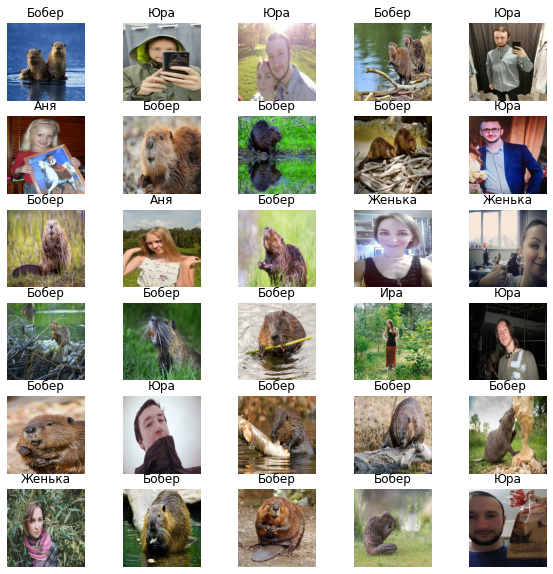

In [9]:
import matplotlib.pyplot as plt

col = 30
row_sythe = 5

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(col):
    ax = plt.subplot(int(col/row_sythe), row_sythe,  i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Стандартизация данных

In [10]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.007843138 1.0


In [12]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
9/9 [==============================] - 9s 972ms/step - loss: 1.8611 - accuracy: 0.3613 - val_loss: 1.1627 - val_accuracy: 0.5909
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 1.2343 - accuracy: 0.5630 - val_loss: 1.1746 - val_accuracy: 0.5909
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 1.0847 - accuracy: 0.5964 - val_loss: 1.0479 - val_accuracy: 0.6667
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.8768 - accuracy: 0.7000 - val_loss: 0.9195 - val_accuracy: 0.6818
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.7320 - accuracy: 0.7251 - val_loss: 0.8047 - val_accuracy: 0.6515
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.5193 - accuracy: 0.8159 - val_loss: 0.7646 - val_accuracy: 0.7273
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.3249 - accuracy: 0.9106 - val_loss: 0.9804 - val_accuracy: 0.6364
Epoch 8/10
9/9 [=================

In [15]:
test_loss, test_accuracy = model.evaluate(val_ds)
print('Проверка на тестовых данных:', str(round(test_accuracy *100, 3)) + str('%'))

3/3 [==============================] - 1s 146ms/step - loss: 0.8776 - accuracy: 0.7273
Проверка на тестовых данных: 72.727%


In [16]:
model.save('../scr/model')

INFO:tensorflow:Assets written to: ../scr/model/assets


In [17]:
for test_images, test_labels in val_ds.take(1):
    test_images = test_images
    test_labels = test_labels
    predictions = model.predict(test_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


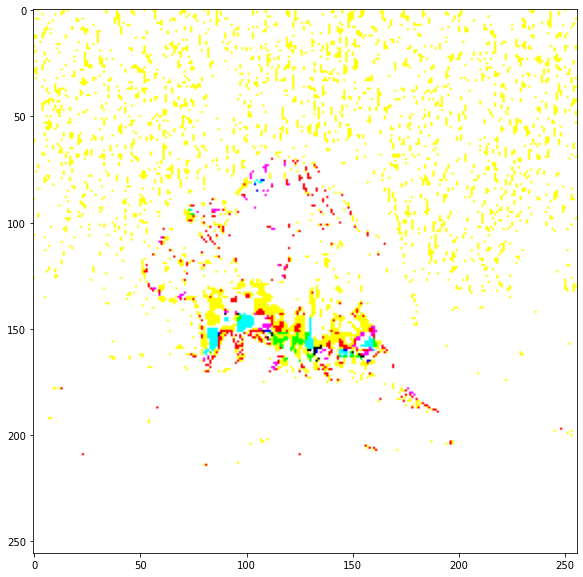

In [18]:
plt.figure(figsize=(20,10))
plt.imshow(test_images[1])
plt.show()

In [19]:
prd_class = []
for id in predictions:
    prd_class.append(np.argmax(id))
str(prd_class)

'[1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 4, 4, 4, 4, 2, 1, 1, 1, 1, 4, 1, 3, 2, 1, 4, 1]'

In [27]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label, col_class):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(col_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

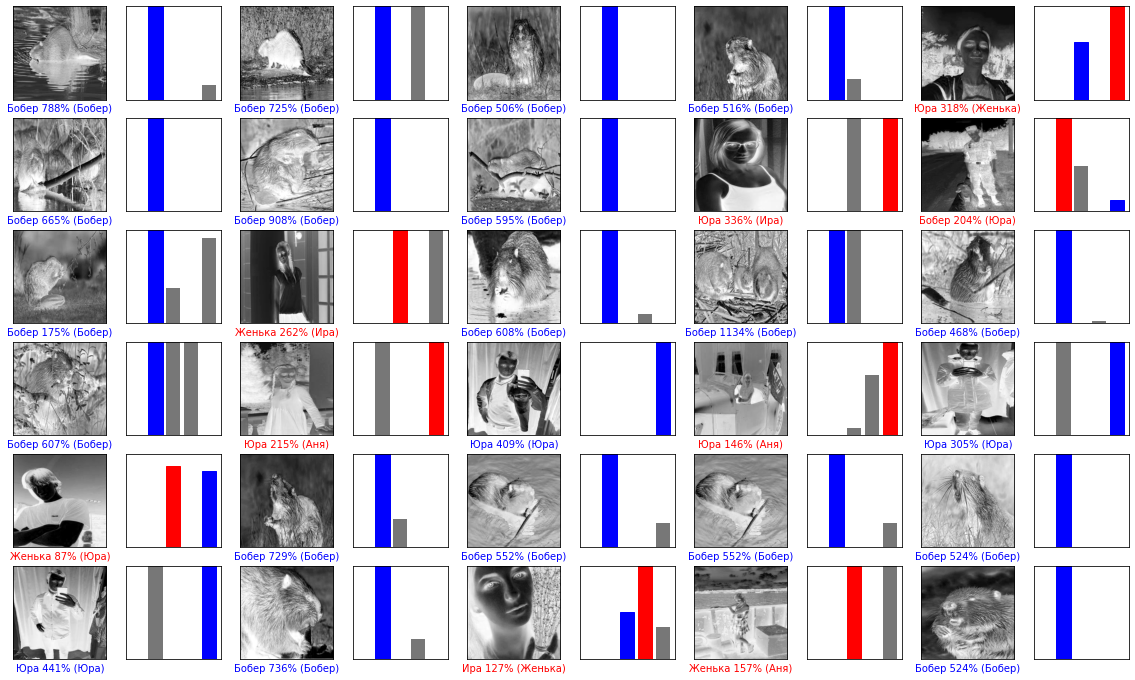

In [30]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_cols = 5
# num_rows = 5
num_rows = int(len(test_labels) / num_cols)
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels, len(class_names))